In [1]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time

# Define constants
fashion_mnist_labels = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']


In [2]:
# Model definitions
class NarrowModel(nn.Module):
    def __init__(self):
        super(NarrowModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class WideModel(nn.Module):
    def __init__(self):
        super(WideModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

In [3]:

# Training and evaluation functions
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses = []
    val_accuracies = []
    start_time = time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        train_losses.append(running_loss/len(train_loader))

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Training Loss: {running_loss/len(train_loader):.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

    training_time = time() - start_time
    return train_losses, val_accuracies, training_time

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [4]:
# Data loading function
def load_fashion_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    fashion_data = datasets.FashionMNIST(root='./data', train=True,
                                       download=True, transform=transform)

    train_size = int(0.8 * len(fashion_data))
    val_size = int(0.1 * len(fashion_data))
    test_size = len(fashion_data) - train_size - val_size

    train_data, val_data, test_data = random_split(
        fashion_data, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [6]:
# Visualization functions
def plot_training_curves(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for model_name, model_results in results.items():
        for opt_name, metrics in model_results.items():
            label = f"{model_name}-{opt_name}"
            ax1.plot(metrics['train_losses'], label=label)
            ax2.plot(metrics['val_accuracies'], label=label)

    ax1.set_title('Training Loss vs. Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Validation Accuracy vs. Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_model_comparison(results):
    models = list(results.keys())
    optimizers = list(results[models[0]].keys())

    accuracies = np.zeros((len(models), len(optimizers)))
    times = np.zeros((len(models), len(optimizers)))

    for i, model in enumerate(models):
        for j, opt in enumerate(optimizers):
            accuracies[i, j] = results[model][opt]['test_accuracy']
            times[i, j] = results[model][opt]['training_time']

    plt.figure(figsize=(10, 6))
    sns.heatmap(accuracies, annot=True, fmt='.2f',
                xticklabels=optimizers, yticklabels=models)
    plt.title('Test Accuracy (%) for Different Models and Optimizers')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(times, annot=True, fmt='.1f',
                xticklabels=optimizers, yticklabels=models)
    plt.title('Training Time (s) for Different Models and Optimizers')
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    with torch.no_grad():
        images, labels = next(iter(test_loader))
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        for idx in range(num_samples):
            img = images[idx].squeeze().numpy()
            true_label = labels[idx].item()
            predicted = outputs[idx].argmax().item()

            axes[idx].imshow(img, cmap='gray')
            axes[idx].axis('off')
            axes[idx].set_title(f'True: {fashion_mnist_labels[true_label]}\n' +
                              f'Pred: {fashion_mnist_labels[predicted]}')

            plt.figure(figsize=(8, 4))
            plt.bar(fashion_mnist_labels, probs[idx].numpy())
            plt.xticks(rotation=45, ha='right')
            plt.title(f'Probability Distribution - Sample {idx+1}')
            plt.tight_layout()
            plt.show()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    cm = np.zeros((10, 10), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=fashion_mnist_labels,
                yticklabels=fashion_mnist_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [7]:

# Main execution
def main():
    # Load data
    train_loader, val_loader, test_loader = load_fashion_data()

    # Define models and optimizers
    models = {
        'Narrow': NarrowModel(),
        'Wide': WideModel(),
        'Deep': DeepModel()
    }

    optimizers = {
        'SGD': lambda m: optim.SGD(m.parameters(), lr=0.01),
        'Adam': lambda m: optim.Adam(m.parameters(), lr=0.001),
        'RMSprop': lambda m: optim.RMSprop(m.parameters(), lr=0.001)
    }

    criterion = nn.CrossEntropyLoss()
    results = {}

    # Train and evaluate each combination
    for model_name, model in models.items():
        model_results = {}
        for opt_name, opt_func in optimizers.items():
            print(f"\nTraining {model_name} with {opt_name}")
            optimizer = opt_func(model)

            train_losses, val_accuracies, training_time = train_model(
                model, train_loader, val_loader, optimizer, criterion
            )

            test_accuracy = evaluate_model(model, test_loader)

            model_results[opt_name] = {
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'test_accuracy': test_accuracy,
                'training_time': training_time
            }

            print(f"Test Accuracy: {test_accuracy:.2f}%")
            print(f"Training Time: {training_time:.2f} seconds")

        results[model_name] = model_results

    # Create visualizations
    plot_training_curves(results)
    plot_model_comparison(results)

    # Get best model
    best_acc = 0
    best_model = None
    for model_name, model_results in results.items():
        for opt_name, metrics in model_results.items():
            if metrics['test_accuracy'] > best_acc:
                best_acc = metrics['test_accuracy']
                best_model = models[model_name]

    # Visualize predictions and confusion matrix for best model
    visualize_predictions(best_model, test_loader)
    plot_confusion_matrix(best_model, test_loader)

    # Print final results
    print("\nFinal Results:")
    print("-" * 50)
    for model_name, model_results in results.items():
        print(f"\n{model_name} Model:")
        for opt_name, metrics in model_results.items():
            print(f"\n{opt_name} Optimizer:")
            print(f"Test Accuracy: {metrics['test_accuracy']:.2f}%")
            print(f"Training Time: {metrics['training_time']:.2f} seconds")
            print(f"Final Validation Accuracy: {metrics['val_accuracies'][-1]:.2f}%")


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.77MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.36MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.69MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Training Narrow with SGD
Epoch 1/10:
Training Loss: 1.1273
Validation Accuracy: 76.53%
Epoch 2/10:
Training Loss: 0.5920
Validation Accuracy: 80.57%
Epoch 3/10:
Training Loss: 0.5184
Validation Accuracy: 83.05%
Epoch 4/10:
Training Loss: 0.4804
Validation Accuracy: 84.02%
Epoch 5/10:
Training Loss: 0.4563
Validation Accuracy: 84.87%
Epoch 6/10:
Training Loss: 0.4379
Validation Accuracy: 84.90%
Epoch 7/10:
Training Loss: 0.4230
Validation Accuracy: 85.43%
Epoch 8/10:
Training Loss: 0.4101
Validation Accuracy: 85.58%
Epoch 9/10:
Training Loss: 0.3990
Validation Accuracy: 85.95%
Epoch 10/10:
Training Loss: 0.3888
Validation Accuracy: 86.42%
Test Accuracy: 86.20%
Training Time: 169.77 seconds

Training Narrow with Adam
Epoch 1/10:
Training Loss: 0.4306
Validation Accuracy: 84.27%
Epoch 2/10:
Training Loss: 0.3741
Validation Accuracy: 87.37%
Epoch 3/10:
Training Loss: 0.3417
Validation Accuracy: 86.67%

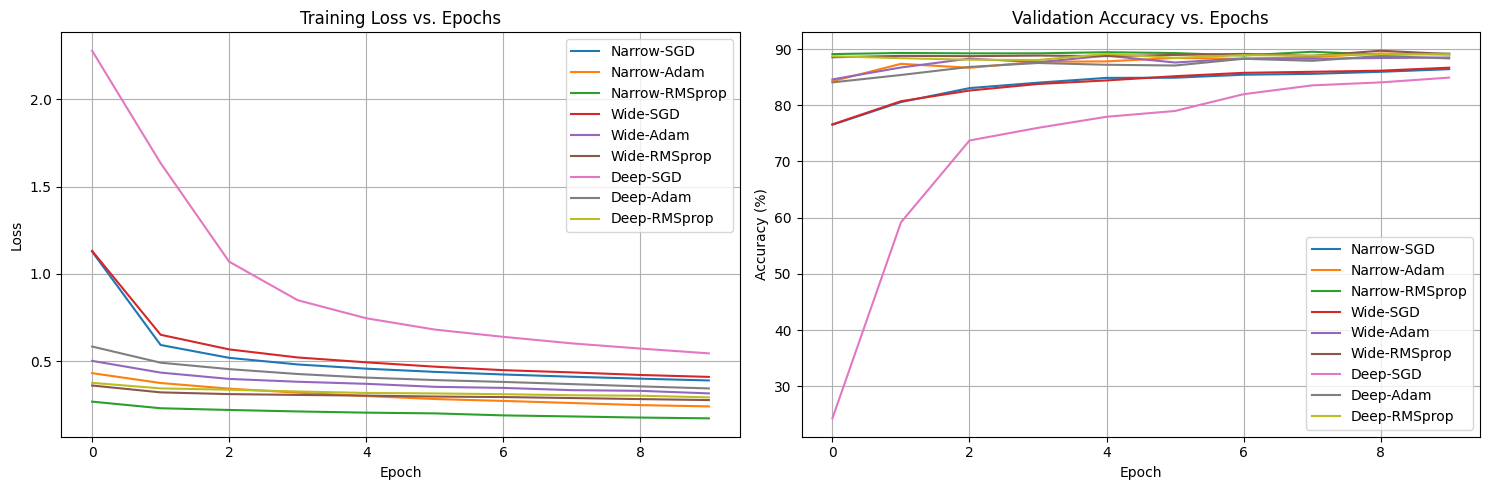

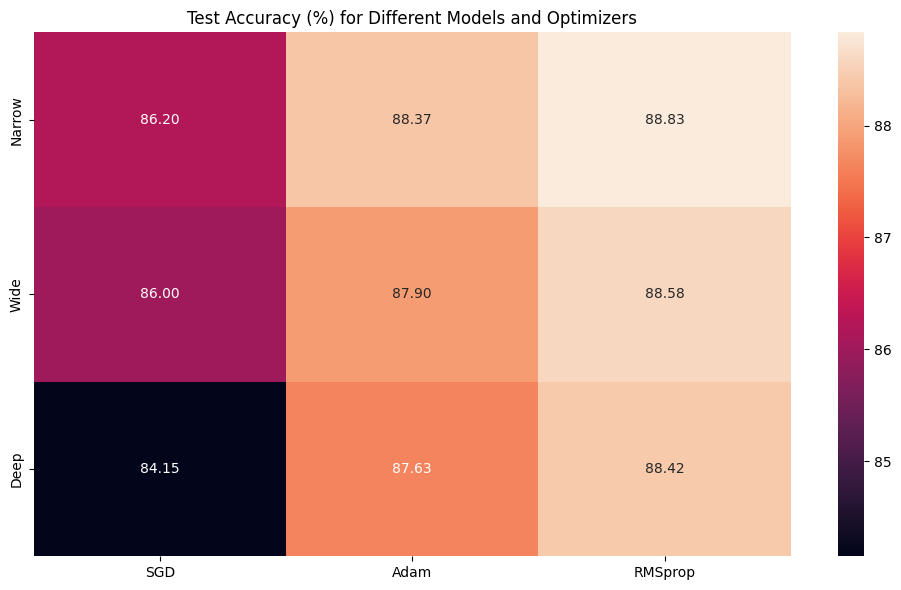

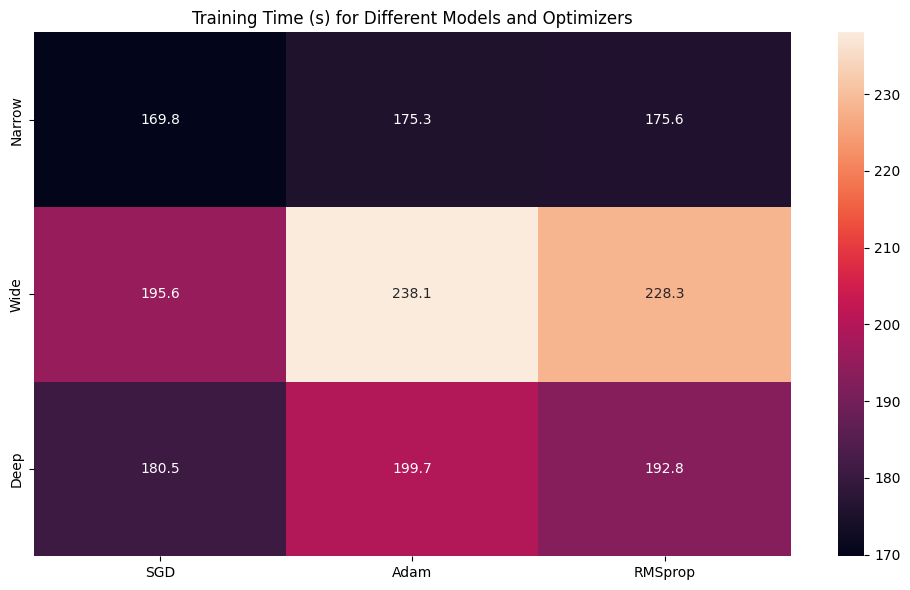

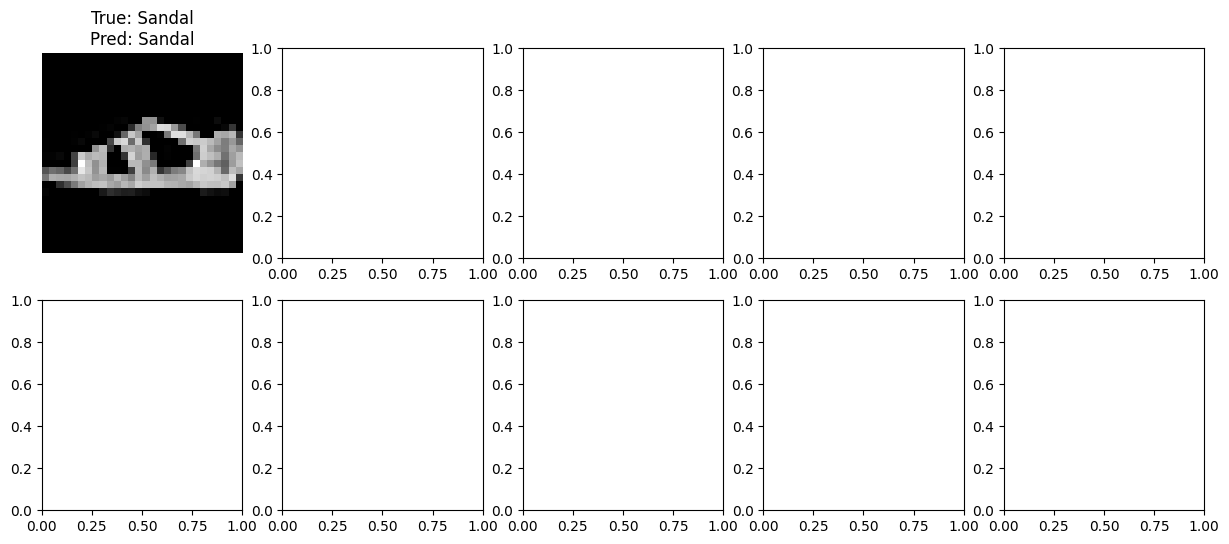

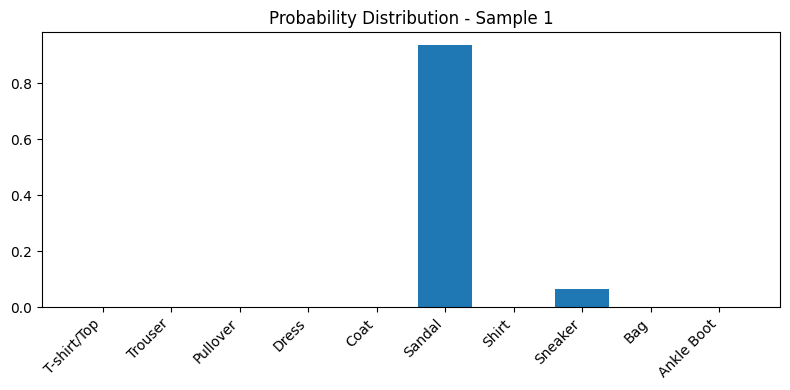

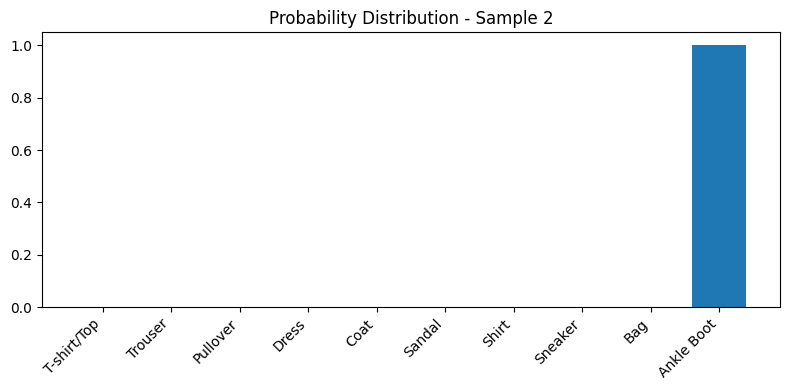

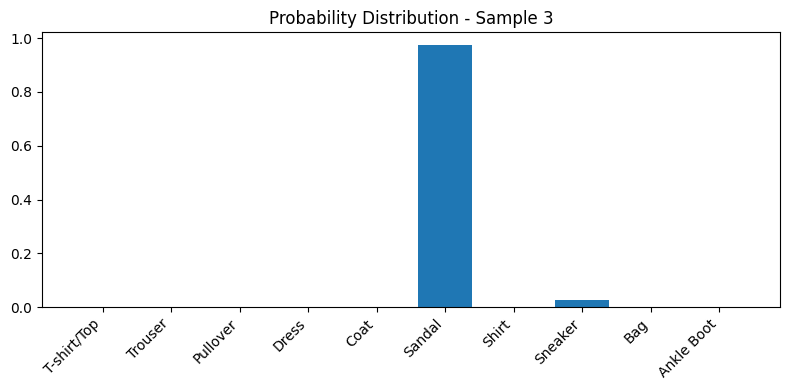

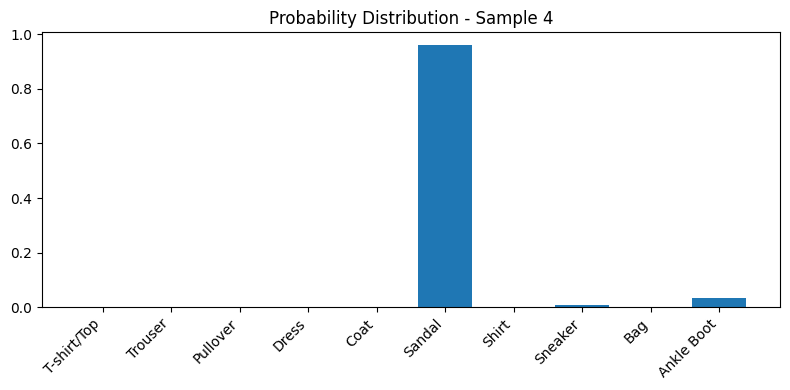

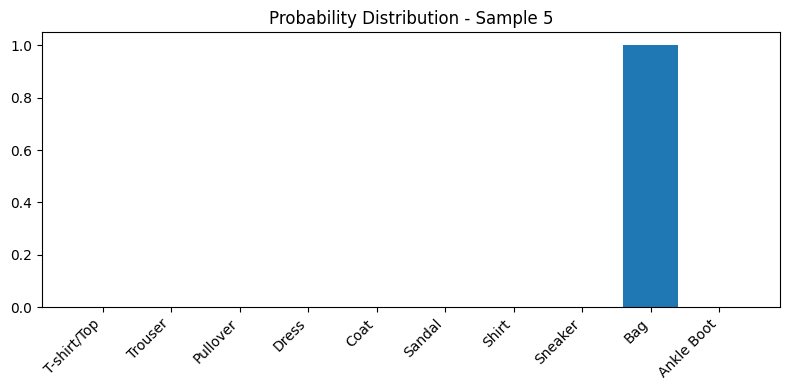

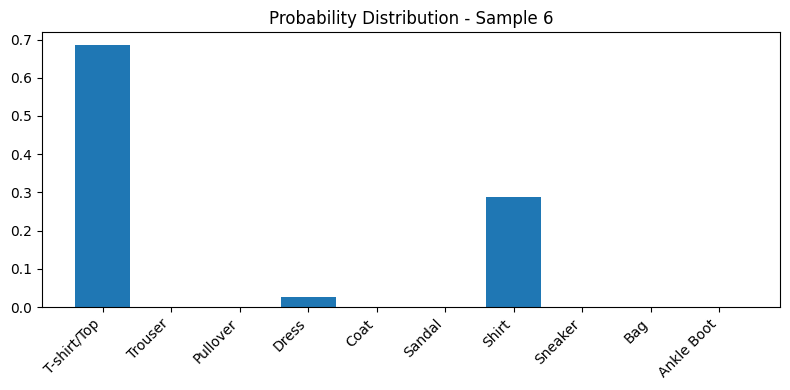

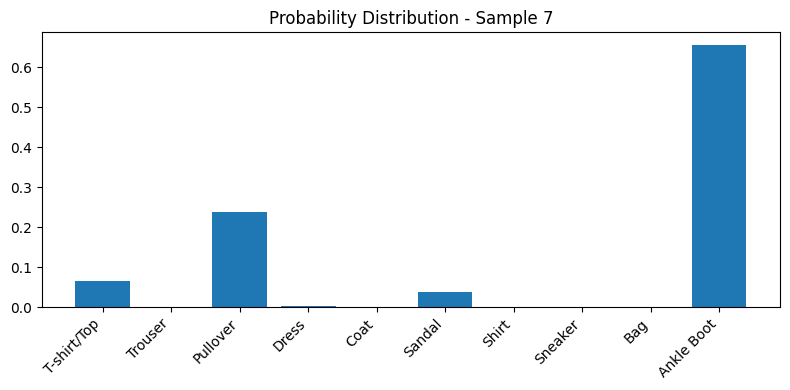

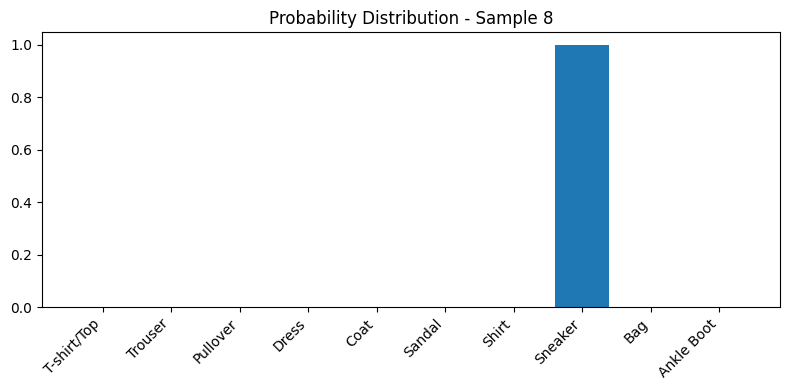

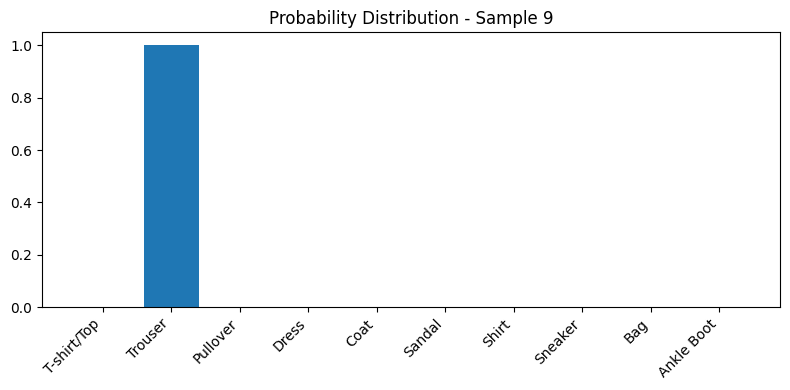

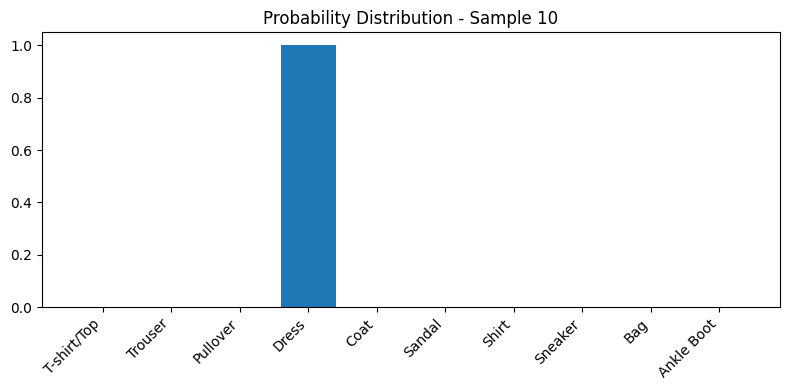

<Figure size 640x480 with 0 Axes>

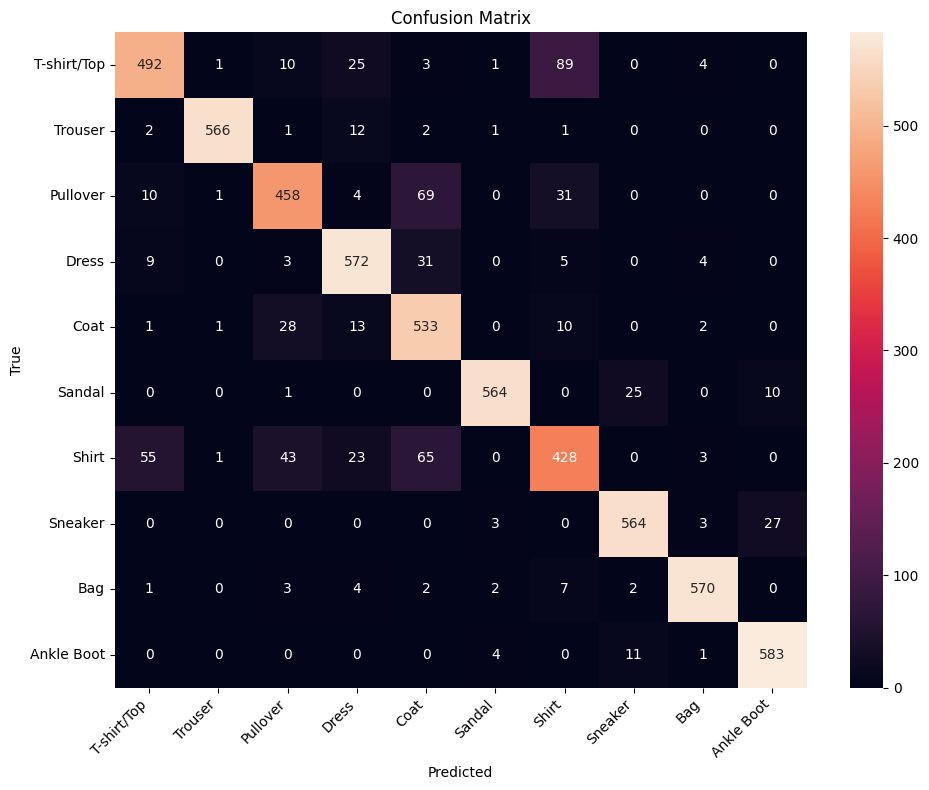


Final Results:
--------------------------------------------------

Narrow Model:

SGD Optimizer:
Test Accuracy: 86.20%
Training Time: 169.77 seconds
Final Validation Accuracy: 86.42%

Adam Optimizer:
Test Accuracy: 88.37%
Training Time: 175.33 seconds
Final Validation Accuracy: 89.02%

RMSprop Optimizer:
Test Accuracy: 88.83%
Training Time: 175.60 seconds
Final Validation Accuracy: 89.18%

Wide Model:

SGD Optimizer:
Test Accuracy: 86.00%
Training Time: 195.60 seconds
Final Validation Accuracy: 86.68%

Adam Optimizer:
Test Accuracy: 87.90%
Training Time: 238.05 seconds
Final Validation Accuracy: 88.50%

RMSprop Optimizer:
Test Accuracy: 88.58%
Training Time: 228.29 seconds
Final Validation Accuracy: 89.10%

Deep Model:

SGD Optimizer:
Test Accuracy: 84.15%
Training Time: 180.46 seconds
Final Validation Accuracy: 84.92%

Adam Optimizer:
Test Accuracy: 87.63%
Training Time: 199.67 seconds
Final Validation Accuracy: 88.33%

RMSprop Optimizer:
Test Accuracy: 88.42%
Training Time: 192.82 s

In [8]:
# Run everything
if __name__ == "__main__":
    main()